In [117]:
import numpy as np
from scipy import linalg as lin
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

# Part 1

The indices in Python start from $0$ so index $5$ in Matlab becomes $4$ in Python and so forth.

In [140]:
M = 101
zmin = 0.
zmax = 1e1
Dz = (zmax - zmin) / (M - 1e0)
z = zmin + Dz*np.arange(M)
mtrue = np.zeros(M)
mtrue[4] = 1.
mtrue[9] = 1.
mtrue[19] = 1.
mtrue[49] = 1.
mtrue[89] = 1.

In [141]:
N = M
cmin = 0.
cmax = 1e-1
Dc = (cmax - cmin)
c = cmin + Dc*np.arange(N)
G = c[:, np.newaxis] * np.exp( - c[:, np.newaxis]*z)

sd = 1e-2
dtrue = np.dot(G, mtrue)
dobs = dtrue + np.random.normal( 0., sd , N )   # Noise: normal distribution with zero mean and 0.01 standard deviation

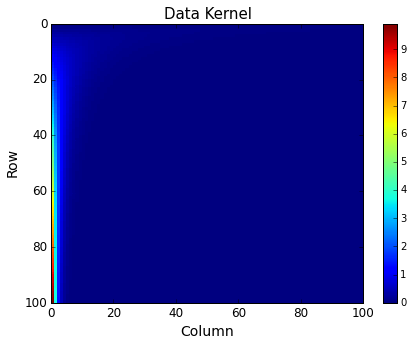

In [142]:
x = np.arange(M)
y = np.arange(N)

fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ca = ax.pcolormesh(x, y, G)
cbar = fig.colorbar(ca)
ax.set_title(r'Data Kernel', fontsize=15)
ax.set_xlabel(r'Column', fontsize=14)
ax.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

In [143]:
print (G*Dz).sum(axis=1)

[ 0.          0.63896522  0.87604689  0.966031    1.00218156  1.01863742
  1.02789485  1.03452796  1.04021105  1.04555697  1.05079003  1.05599233
  1.06119393  1.06640582  1.07163203  1.07687401  1.08213232  1.08740714
  1.09269853  1.09800652  1.10333111  1.1086723   1.11403008  1.11940445
  1.1247954   1.13020292  1.135627    1.14106763  1.14652481  1.15199853
  1.15748877  1.16299554  1.16851881  1.17405857  1.17961482  1.18518755
  1.19077674  1.19638239  1.20200447  1.20764298  1.21329791  1.21896924
  1.22465696  1.23036106  1.23608152  1.24181832  1.24757146  1.25334091
  1.25912667  1.26492872  1.27074704  1.27658162  1.28243243  1.28829947
  1.29418272  1.30008215  1.30599776  1.31192951  1.31787741  1.32384142
  1.32982153  1.33581772  1.34182997  1.34785826  1.35390257  1.35996288
  1.36603917  1.37213141  1.3782396   1.38436371  1.3905037   1.39665958
  1.4028313   1.40901885  1.41522221  1.42144135  1.42767625  1.43392689
  1.44019324  1.44647528  1.45277298  1.45908632  1

We see above that the normalization of G is approximately satisfied, i.e. 

$$\int G(z) \ dz \simeq 1$$

# Part 2

The Python algorithm for singular value decomposition gives

$$U, L, V^T = svd(G)$$

In [144]:
U, L, V = lin.svd(G)

print U.shape, L.shape, V.shape

(101, 101) (101,) (101, 101)


(array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 8 Text yticklabel objects>)

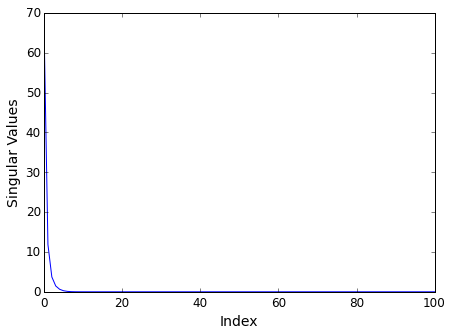

In [145]:
fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ax.plot(L)
ax.set_xlabel(r'Index', fontsize=14)
ax.set_ylabel(r'Singular Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

From the figure above, we shall choose $p$ as $7$. The natural solution is derived as

$$\boldsymbol{m}^{est} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T \boldsymbol{d}^{obs}$$

In [125]:
p = 7
Up = U[:, :p].copy()
Vp = V.T[:, :p].copy()
Lp = L[:p].copy()
# Lambdap1 = 1./Lp
# print Lambdap1.shape

In [126]:
# mest_Nat = np.dot(np.dot( np.dot( Vp, Lambdap1 ), Up.T), dobs )
mest_Nat = np.dot( Vp, np.dot(Up.T, dobs) / Lp ) 
print mest_Nat.shape

(101,)


The model-parameter estimates for damped least square is

$$\boldsymbol{m}^{est} = \big[ \boldsymbol{G}^T \boldsymbol{G} + \epsilon^2 \boldsymbol{I} \big]^{-1} \boldsymbol{G}^T \boldsymbol{d}^{obs} $$

In [127]:
eps = 1e-2
mest_DLS = np.dot( np.dot( lin.inv( np.dot(G.T, G) + eps**2*np.identity(M) ), G.T ), dobs )

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

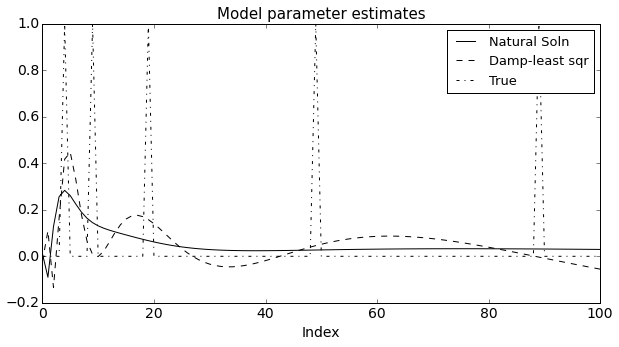

In [128]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln')
ax.plot(mest_DLS, 'k--', label=r'Damp-least sqr')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Comments

The natural solution has more negative values compared to the damped least square solution, which is an undesirable feature since the true model parameters are all non-negative. Except for the first peak in the true model parameters which the natural solution predicts correctly, neither of the estimated model parameters get the location of the true peaks exactly. It is interesting the natural solution is almost flat below the depth of 30. We could try to incorporate the effects of the peaks at deeper depths in the natural solution by increasing $p$ but this would also increase more sidelobes.

The model resolution matrix and unit covariance matrix are

$$ \boldsymbol{R} = \boldsymbol{G}^{-g} \boldsymbol{G} = \boldsymbol{V}_P \boldsymbol{V}_P^T $$

$$ \boldsymbol{N} = \boldsymbol{G} \boldsymbol{G}^{-g} = \boldsymbol{U}_P \boldsymbol{U}_P^T $$

$$ cov_u( \boldsymbol{m}^{est} ) = {\sigma_d}^{-2} \boldsymbol{G}^{-g} cov( \boldsymbol{d}^{obs} ) {\boldsymbol{G}^{-g}}^T = \boldsymbol{G}^{-g} {\boldsymbol{G}^{-g}}^T $$

where $\boldsymbol{G}^{-g} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T $.

In [129]:
print Up.shape, Vp.shape, Lp.shape

(101, 7) (101, 7) (7,)


In [130]:
Lambdap1 = Lp * np.identity(p)
print Lambdap1

R = np.dot(Vp, Vp.T)
DatRes = np.dot(Up, Up.T)
Gg = np.dot( np.dot( Vp, lin.inv(Lambdap1) ), Up.T )
cov_m = np.dot( Gg, Gg.T )

[[ 66.83560925   0.           0.           0.           0.           0.
    0.        ]
 [  0.          11.85102499   0.           0.           0.           0.
    0.        ]
 [  0.           0.           3.7208841    0.           0.           0.
    0.        ]
 [  0.           0.           0.           1.45955949   0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.62776809   0.
    0.        ]
 [  0.           0.           0.           0.           0.           0.26486238
    0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.10389341]]


In [131]:
print DatRes

[[  2.51864051e-28   3.93144089e-15  -1.08609897e-16 ...,   3.17599742e-15
    3.67058455e-15   4.18812132e-15]
 [  3.93144089e-15   6.15520726e-01   3.91452257e-01 ...,   2.36512474e-02
    2.89188354e-02   3.45159088e-02]
 [ -1.08609897e-16   3.91452257e-01   3.52610644e-01 ...,  -2.71047359e-03
   -3.13264676e-03  -3.56924746e-03]
 ..., 
 [  3.17599742e-15   2.36512474e-02  -2.71047359e-03 ...,   1.13633864e-01
    1.22569845e-01   1.31791072e-01]
 [  3.67058455e-15   2.89188354e-02  -3.13264676e-03 ...,   1.22569845e-01
    1.32634570e-01   1.43029919e-01]
 [  4.18812132e-15   3.45159088e-02  -3.56924746e-03 ...,   1.31791072e-01
    1.43029919e-01   1.54646871e-01]]


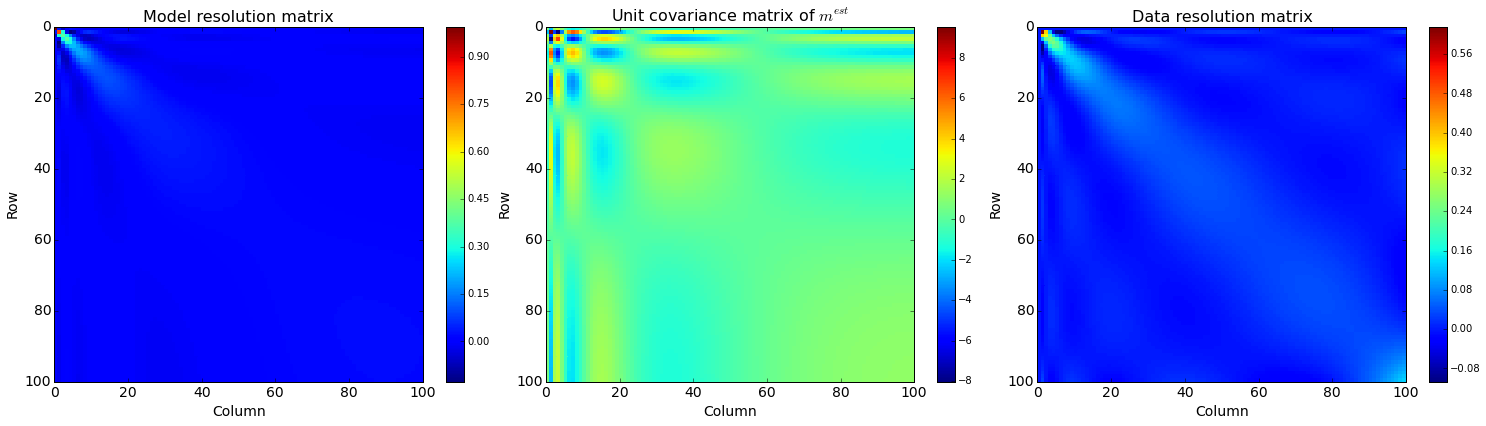

In [132]:
x = np.arange(101)
y = x.copy()

fig = plt.figure(figsize=(21,6))

ax1 = fig.add_subplot(131)
ca1 = ax1.pcolormesh(x, y, R)
cbar = fig.colorbar(ca1)
ax1.set_title(r'Model resolution matrix', fontsize=16)
ax1.set_xlabel(r'Column', fontsize=14)
ax1.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax2 = fig.add_subplot(132)
ca2 = ax2.pcolormesh(x, y, cov_m)
cbar = fig.colorbar(ca2)
ax2.set_title(r'Unit covariance matrix of $m^{est}$', fontsize=16)
ax2.set_xlabel(r'Column', fontsize=14)
ax2.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax3 = fig.add_subplot(133)
ca3 = ax3.pcolormesh(x, y, DatRes)
cbar = fig.colorbar(ca3)
ax3.set_title(r'Data resolution matrix', fontsize=16)
ax3.set_xlabel(r'Column', fontsize=14)
ax3.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()


The spread and size of matrix $\boldsymbol{R}$ and vector $\boldsymbol{m}$ is defined as

$$ spread(\boldsymbol{R}) = || \boldsymbol{R} - \boldsymbol{I} ||^2_2, \ \ \ \ size( cov_u( \boldsymbol{m}) ) = \big| \big| var_u( \boldsymbol{m} )^{1/2} \big| \big|_2^2 $$

In [133]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

94.0 109.986635807


## Comments

The spread of the model resolution matrix is $94.0$ and the size of the unit covariance matrix of the estimated model parameters is $110$.

In [146]:
for p in range(N, -1, -1):

    Up = U[:, :p].copy()
    Vp = V.T[:, :p].copy()
    Lp = L[:p].copy()
    Lambdap1 = Lp * np.identity(p)
    
    mest_Nat = np.dot( Vp, np.dot(Up.T, dobs) / Lp ) 
    
    R = np.dot(Vp, Vp.T)
    DatRes = np.dot(Up, Up.T)
    Gg = np.dot( np.dot( Vp, lin.inv(Lambdap1) ), Up.T )
    cov_m = np.dot( Gg, Gg.T )
    
    spR = ( (R - np.identity(M))**2 ).sum()
    szm = ( np.diagonal(cov_m) ).sum()
    
    
    if all( i < 1 for i in np.diagonal(cov_m) ):
        print p
        break

5


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

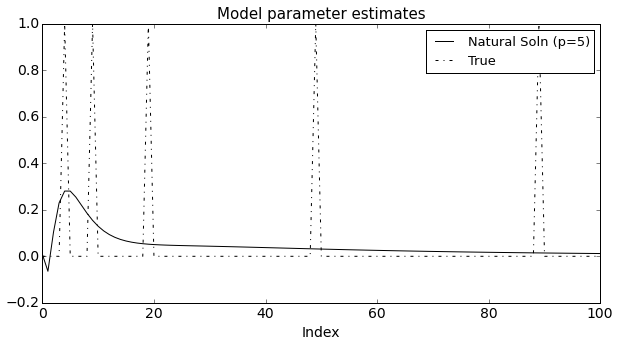

In [147]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln (p=5)')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

As $p$ grows larger, the noise increases as well due to smaller scale fluctuations in the estimated model parameters. Thus, we shall choose the largest $p$ which satisfies the condition of the diagonal elements of unit covariance matrix being less than unity for all depths. From the figure above, we see that the natural solution $\boldsymbol{m}^{est}_{NatSoln}$ gets the location of the first peak in $\boldsymbol{m}^{true}$ right but the smaller scale features are smudged out.

In [136]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

96.0 3.08646028099


## Comments

The spread of the model resolution matrix is $96.0$ and the size of the unit covariance matrix of the estimated model parameters is $3.09$. The size for $p=5$ has significantly decreased compared to the case of $p=7$ but the spreads are approximately the same for both cases, which means that the resolutions are equivalent.

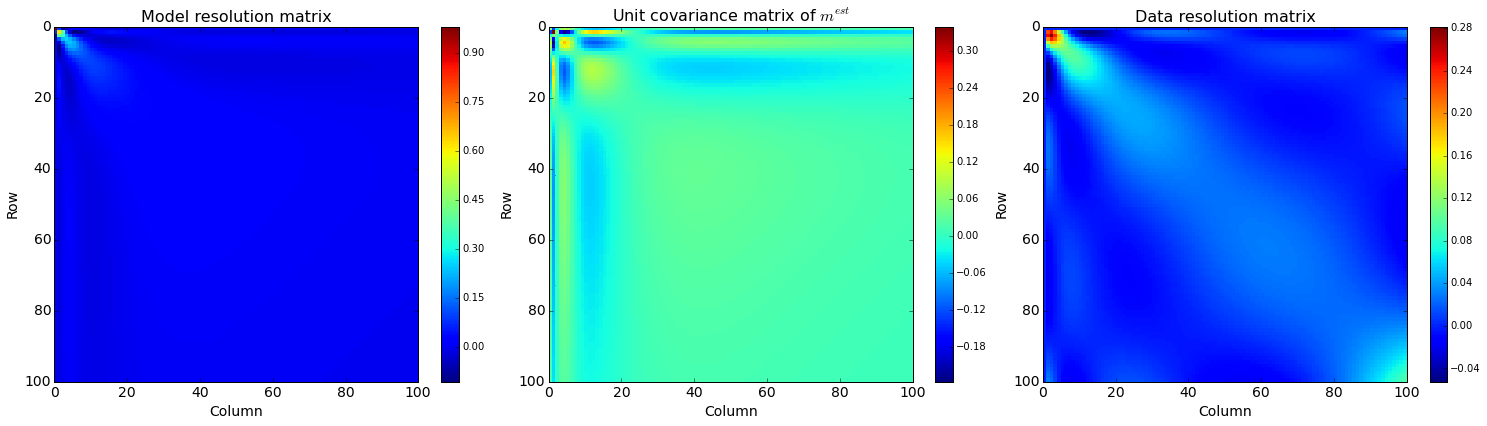

In [137]:
x = np.arange(101)
y = x.copy()

fig = plt.figure(figsize=(21,6))

ax1 = fig.add_subplot(131)
ca1 = ax1.pcolormesh(x, y, R)
cbar = fig.colorbar(ca1)
ax1.set_title(r'Model resolution matrix', fontsize=16)
ax1.set_xlabel(r'Column', fontsize=14)
ax1.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax2 = fig.add_subplot(132)
ca2 = ax2.pcolormesh(x, y, cov_m)
cbar = fig.colorbar(ca2)
ax2.set_title(r'Unit covariance matrix of $m^{est}$', fontsize=16)
ax2.set_xlabel(r'Column', fontsize=14)
ax2.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax3 = fig.add_subplot(133)
ca3 = ax3.pcolormesh(x, y, DatRes)
cbar = fig.colorbar(ca3)
ax3.set_title(r'Data resolution matrix', fontsize=16)
ax3.set_xlabel(r'Column', fontsize=14)
ax3.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
